In [1]:
import numpy as np
from birkeland import Model, BetterModel
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

# Reproduce the plots from Milan (2013)
The below code instantiates the two examples from Milan (2013) and attempts to reproduce the plots from Milan (2013).

In [2]:
example1 = Model(50, 0, 0.4)
example2 = Model(30, 70, 0.7)

## Reproduce Figure 2a–d

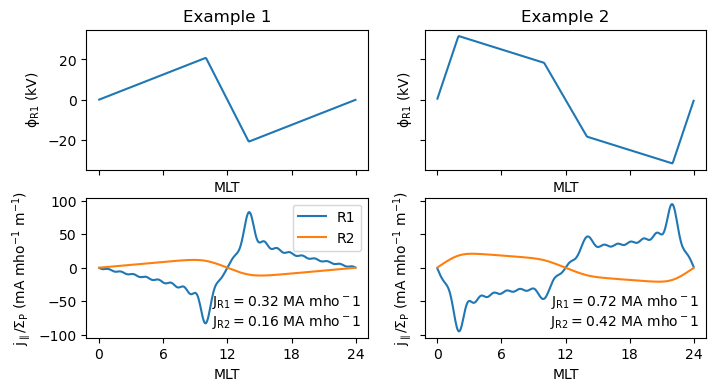

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(8, 4), sharex="all", sharey="row")

for cnt, example in enumerate((example1, example2)):
    example.plot_r1_potential(ax[0, cnt])
    example.plot_r1_and_r2_intensity(ax[1, cnt])
    
ax[1, 0].legend(loc="upper right")
ax[0, 0].set(title="Example 1")
ax[0, 1].set(title="Example 2")

plt.show()

## Reproduce the contours in Figure 2e-j

The contours are at intervals of 10 kV from 5 kV upward; the 6 kV interval stated in the caption to Figure 2 is a typographical error.

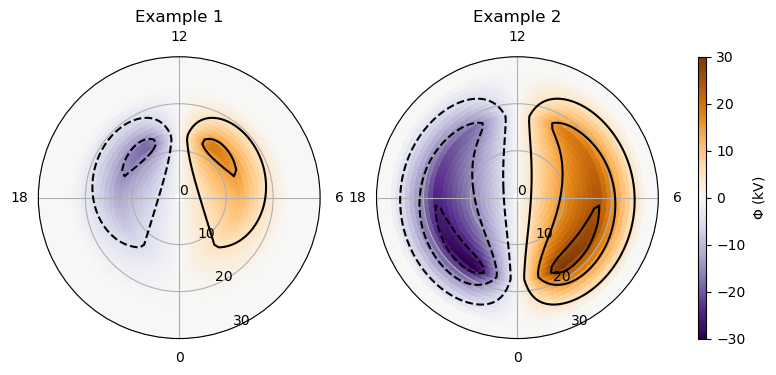

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={"polar": True})
mesh = np.empty_like(ax, dtype=object)

for cnt, example in enumerate([example1, example2]):
    mesh[cnt] = example.map_electric_potential(ax[cnt])
    ax[cnt].set_title(f"Example {cnt + 1}")

cax = example.add_cax(fig, ax)
cbar = plt.colorbar(mesh[0], cax=cax)
cbar.ax.yaxis.set_major_locator(MaxNLocator(6))
cbar.set_label(r"$\mathregular{\Phi}$ (kV)")

## Reproduce the maps in Figures 2e-h

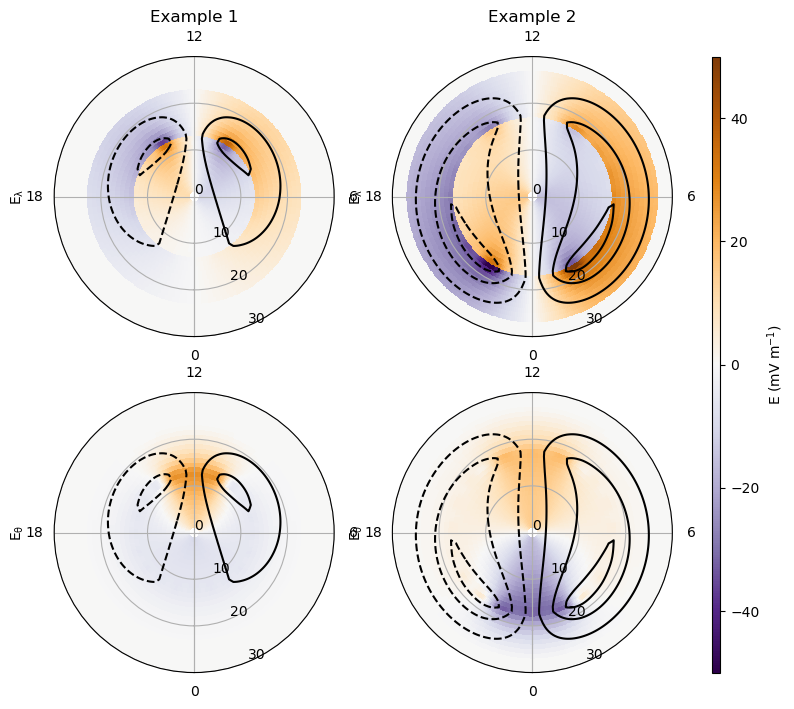

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={"polar": True})
mesh = np.empty_like(ax, dtype=object)

for col, example in enumerate([example1, example2]):
    for row, component in enumerate(["labda", "theta"]):
        mesh[row, col] = example.map_electric_field(ax[row, col], component)
    ax[0, col].set_title(f"Example {col + 1}")
        
cax = example.add_cax(fig, ax)
cbar = plt.colorbar(mesh[0, 0], cax=cax)
cbar.ax.yaxis.set_major_locator(MaxNLocator(6))
cbar.set_label(r"E (mV m$^{-1}$)")

## Reproduce Figure 2i–j

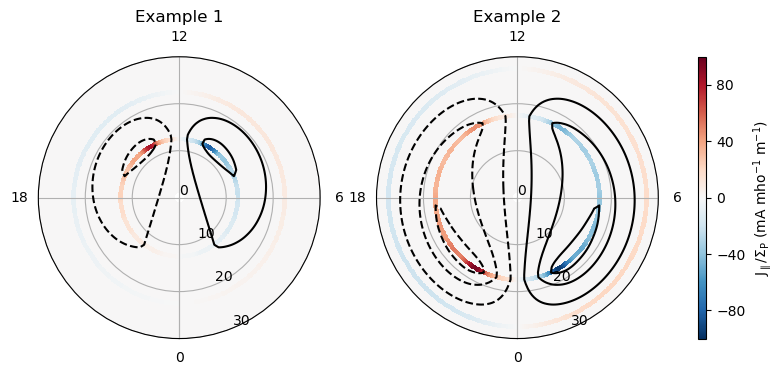

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={"polar": True})
mesh = np.empty_like(ax, dtype=object)

for cnt, example in enumerate([example1, example2]):
    mesh[cnt] = example.map_current(ax[cnt])
    ax[cnt].set_title(f"Example {cnt + 1}")

cax = example.add_cax(fig, ax)
cbar = plt.colorbar(mesh[0], cax=cax)
cbar.ax.yaxis.set_major_locator(MaxNLocator(6))
cbar.set_label(r"$\mathregular{J_\parallel/\Sigma_P}$ (mA mho$^{-1}$ m$^{-1}$)")

## Plot the ionospheric flow vector

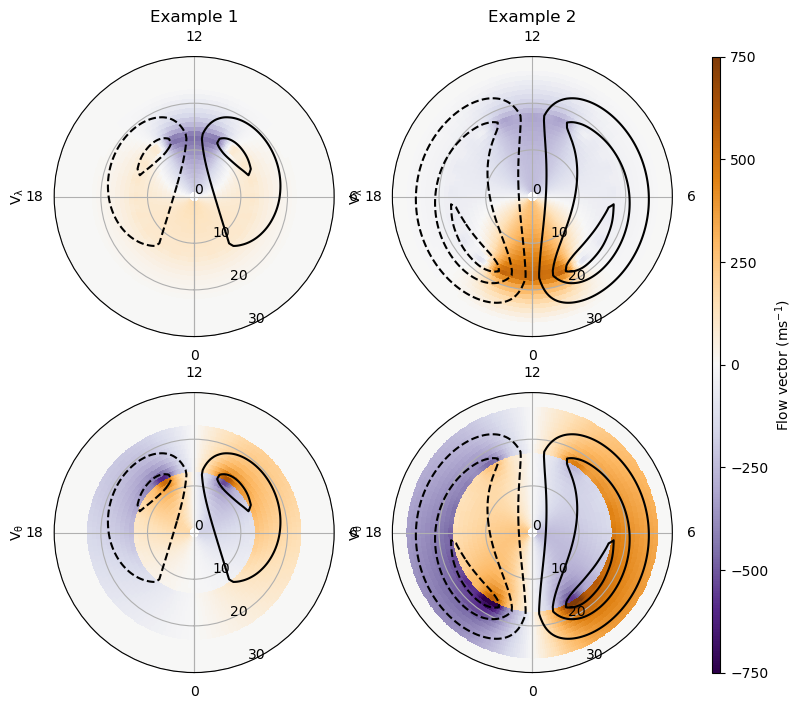

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={"polar": True})
mesh = np.empty_like(ax, dtype=object)

for col, example in enumerate([example1, example2]):
    for row, component in enumerate(["labda", "theta"]):
        mesh[row, col] = example.map_flow_vector(ax[row, col], component)
    ax[0, col].set_title(f"Example {col + 1}")
    
cax = example.add_cax(fig, ax)
cbar = plt.colorbar(mesh[0, 0], cax=cax)
cbar.ax.yaxis.set_major_locator(MaxNLocator(6))
cbar.set_label(r"Flow vector (ms$^{-1}$)")

# Implement changes

In [8]:
import datetime as dt
model = BetterModel(8.09364 * 1.7, 8.09364 * 1.7, 78.8214, dt.datetime(2010,1,1,17), "north",
                    f_pc=0.3, r1_colat=15, delta_colat=7)

/opt/homebrew/Caskroom/mambaforge/base/envs/work/lib/python3.10/site-packages/birkeland/__init__.py:53: UserWarning: Setting both polar cap flux and R1 colatitude will set both manually. This is supported to allow comparisons with the original IDL, but is not recommended.
  warnings.warn("Setting both polar cap flux and R1 colatitude will set both manually. "


In [9]:
div_jh, div_jp, fac = model.currents()

In [10]:
from scipy.io import readsav

sav = readsav("../3_0_17.sav")

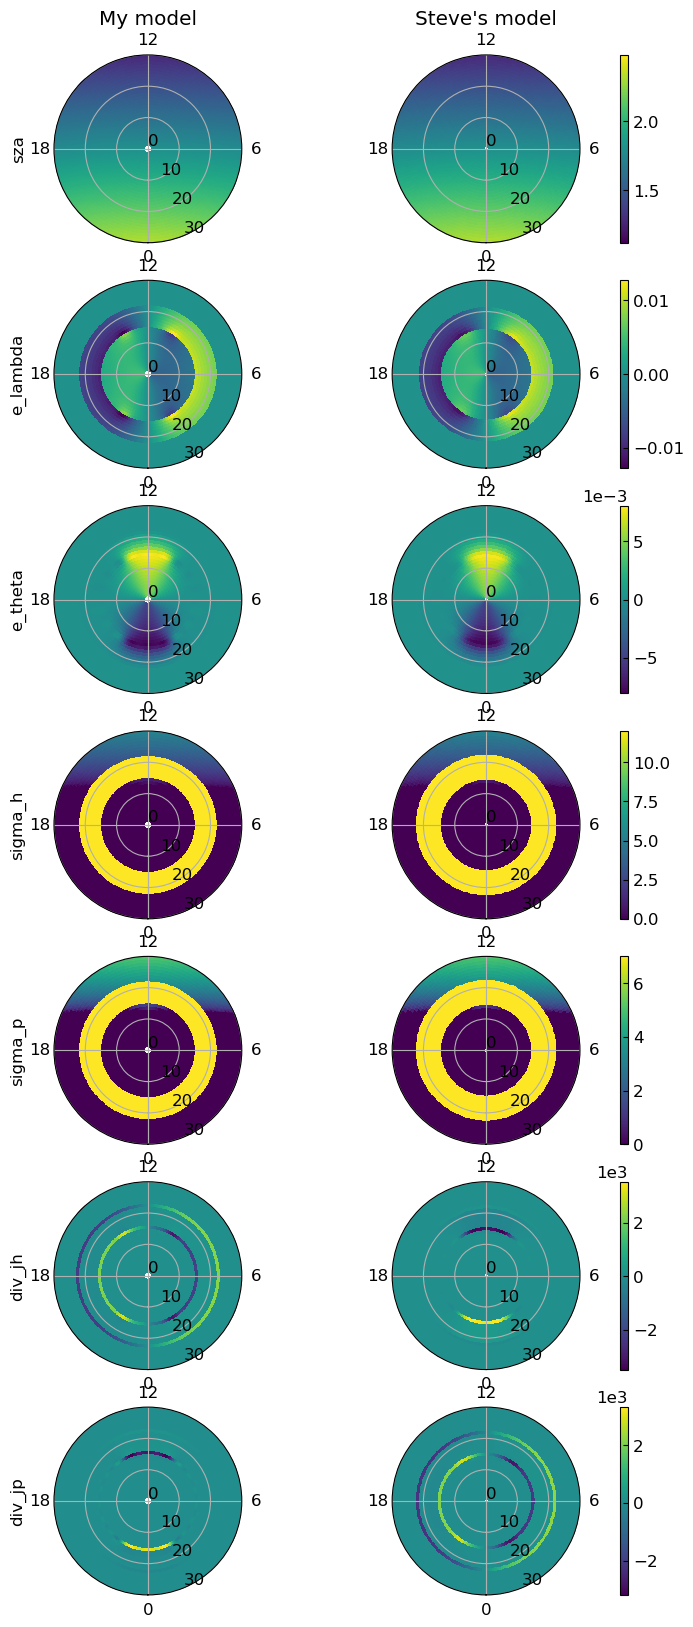

In [11]:
from johncoxon.plot import add_cax, configure_polar_plot, save_figure

fig, ax = plt.subplots(7, 2, figsize=(8, 20), subplot_kw={"polar": True})
mesh = np.empty_like(ax, dtype=object)

ax[0, 0].set_title("My model")
ax[0, 1].set_title("Steve's model")

model_variables = [model.sza, model.e_labda, model.e_theta, model.sigma_h, model.sigma_p, div_jh, div_jp]
for row, variable in enumerate(model_variables):
    mesh[row, 0] = ax[row, 0].pcolormesh(model.theta, model.colat, variable, shading="nearest")

for row, variable in enumerate(["sza", "e_lambda", "e_theta", "sigma_h", "sigma_p", "div_jh", "div_jp"]):
    if variable == "sza":
        plot = np.radians(sav["sza"])
    else:
        plot = sav[variable]
    mesh[row, 1] = ax[row, 1].pcolormesh(np.radians(np.arange(0, 360, 2)), np.arange(40), 
                                         plot.T, shading="nearest")
    ax[row, 0].set_ylabel(variable, labelpad=20)

    cax = add_cax(fig, ax[row, :])
    clim0 = mesh[row, 0].get_clim()
    clim1 = mesh[row, 1].get_clim()
    for i in [0, 1]:
        mesh[row, i].set_clim(np.min((clim0, clim1)), np.max((clim0, clim1)))
    plt.colorbar(mesh[row, 0], cax=cax)

for a in ax.flatten():
    configure_polar_plot(a, 30)